# Trabalho Prático Aprendizagem Automática


In [1]:
import re, pickle, time, datetime
from tempfile import TemporaryDirectory

from sklearn.svm import LinearSVC,SVC

import numpy as np

from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV,RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import cross_val_score , GridSearchCV , RandomizedSearchCV

from sklearn.metrics import confusion_matrix, silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA , TruncatedSVD
from sklearn.pipeline import Pipeline


from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
#Possiveis de serem usadas : numpy, scipy, matplotlib, sklearn, nltk, re e opencv 

Carregar os ficheiros dump

In [82]:
with open('imdbCriticas.p', 'rb') as f:
    global D, Docs, y
    D = pickle.load(f)
    Docs = D.data
    y = D.target
print('done criticas')

with open('tfidf_dump.p', 'rb') as f:
    global tfidf
    tfidf = pickle.load(f)
print('done tfidf')

with open('docs_dump.p', 'rb') as f:
    X = pickle.load(f)
print('done docs')

with open('vector_dump.p', 'rb') as f:
    global vector
    vector = pickle.load(f)
print('done')

done criticas
done tfidf
done docs
done


In [3]:
vector.shape

(40000, 174366)

### Quantidade de reviews por categoria
Podemos analisar a quantidade de reviews de cada uma das possíveis reviews

{1: 8352, 2: 3690, 3: 3923, 4: 4245, 7: 3744, 8: 4529, 9: 3612, 10: 7905}


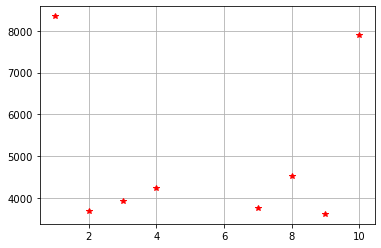

In [4]:
rating, value=np.unique(y,return_counts=True)
print(dict(zip(rating, value)))
plt.plot(rating,value,'*r')
plt.grid()

###  Pré processamento de dados de texto

Usamos este metodo para préprocessar os dados de texto, e reduzir as palavras tendo em conta os erros de ortografia

O stemmer por defeito é o lancaster, porque teve os melhores resultados e se o argumento não corresponder a nenhum outro, este é utilizado

In [5]:
def preProcessDoc(Doc, stemmer = 'lancaster', decode = False):
    """
    Transforma um documento numa forma passivel de ser vetorizada removendo ruido e erros ortograficos
    
    Parameters
    ----------
    Doc :str
        documento para prá Processar
    stemmer : str
        stemmer a utilizar, escolher entre porter, snowball, lancaster
        defaults to lancaster
    decode : boolean
        se a string não estiver descodificada, descodifica em formato utf-8
        defaults to False
    Returns
    ---------
    str
        uma string semelhante á original mas passivel de ser vetorizada para representacao TF-IDF
    """
    stem = {
        'porter'   : PorterStemmer(),
        'snowball' : SnowballStemmer('english'),
        'lancaster': LancasterStemmer()
    }
    stemFunc = stem.get(stemmer, LancasterStemmer())
    if(decode):
        Doc = Doc.decode('UTF-8')
    Doc = Doc.replace('<br />', ' ')
    Doc = re.sub(r'[^a-zA-Z\u00C0\u00FF]+', ' ', Doc)
    Doc = ' '.join([stemFunc.stem(w) for w in Doc.split()])
    return Doc

def preProcessDocs(Docs, stemmer='lancaster', decode = False):
    """
    Metodo que pré processa uma lista de strings para uma forma passivel de ser vetorizada para representacao TF-IDF
    Não é obrigatório chamar este método para converter para representação, mas é recomendado pois melhora o resultado dos classificadores.
    
    Parameters
    ----------
    Doc : list of str
        documento para prá Processar
    stemmer : str
        stemmer a utilizar, escolher entre porter, snowball, lancaster
        defaults to lancaster
    decode : boolean
        se a string não estiver descodificada, descodifica em formato utf-8
        defaults to False
    
    Returns
    ---------
    list
        lista com strings preproprecessadas
    
    See Also
    ---------
    preProcessDoc : Método que ira processar uma unica string
    """
    
    return [preProcessDoc(doc, stemmer, decode) for doc in Docs]

def text2vector(Docs, tfidf=None, preProcess = False, stemmer='lancaster', decode=False):
    """
    Transforma uma string ou lista de strings numa matriz de dimensões (len(Docs), len(tfidf.get_feature_names()))
    
    Parameters
    ----------
    Docs : list of str
        Documentos para vetorizar. Cada documento irá corresponder a uma linha da nova matriz
    
    tfidf : TfidfVectorizer
        Transformador a utilizar para criar a matriz termo dos documentos. 
        Defaults to None , neste caso importa um transformador previamente treinado.
    
    preProcess : boolean
        Se os documentos devem ser pré processados antes de serem transformados na matriz-termo
    
    See Also
    ---------
    preProcessDocs : Metodo que irá pre processar um conjunto de string
    preProcessDoc : Método que ira pre processar uma unica string
    """
    
    if(preProcess):
        Docs = preProcessDocs(Docs, stemmer=stemmer, decode=decode)
    
    if(tfidf==None):
        tfidf = pickle.load(open('tfidf_dump.p','rb'))

    return tfidf.transform(Docs)

def binClassify(X, clf=None):
    """
    Classifica uma matriz de formato (n_components, n_features) em termos de positivo / negativo, tendo em conta o classificador fornecido
    
    Parameters
    ----------
    X : np.array or scipy.sparse
        Matriz para ser classificada. 
        Deve ter rigorosamente o mesmo numero de features da matriz utilizada para treinar o classificador.
    
    clf : SKLearn object that implements predict
        Classificador, deve implementar o método predict e ter sido previamente treinado
        defaults to None, nesse caso importa um classificador previamente treinado 
    """
    if(clf==None):
        clf = pickle.load(open('svc_bool_dump.p' , 'rb'))
    
    return clf.predict(X)

def multiClassify(X, clf=None):
    """
    Classifica uma matriz de formato (n_components, n_features) no conjunto de classes do classificador
    
    Parameters
    ----------
    X : np.array or scipy.sparse
        Matriz para ser classificada. 
        Deve ter rigorosamente o mesmo numero de features da matriz utilizada para treinar o classificador.
    
    clf : SKLearn object that implements predict
        Classificador, deve implementar o método predict e ter sido previamente treinado
        defaults to None, nesse caso importa um classificador previamente treinado 
    """
    
    if(clf==None):
        clf = pickle.load(open('RidgeMultidump.p', 'rb'))
    return clf.predict(X)

## Classificação Binária

Converter da escala de 0 a 10, para negativos/positivos

In [6]:
y_boolean = [0 if val<5 else 1 for val in y]

### Steemers

O stemmer reduz uma palavra á sua raiz, ou seja, remove plurais, conjugacao de verbos, etc

#### Sem Steeming

In [7]:
tfidf_raw = TfidfVectorizer(min_df=3, token_pattern=r'\b[a-zA-Z]{3,}\b').fit(Docs)
vector = text2vector(X, tfidf=tfidf_raw)
dl_raw = LogisticRegression(max_iter = 1000, C=3.3, tol = 1e-3).fit(vector,y_boolean)
print('Token len' , len(tfidf_raw.get_feature_names()))
print(dl_raw.score(vector, y_boolean))

Token len 40269
0.50525


#### Porter

In [8]:
X = preProcessDocs(Docs, stemmer='porter')
tfidf_p = TfidfVectorizer(min_df=3, token_pattern=r'\b[a-zA-Z]{3,}\b').fit(X)
vector = text2vector(X, tfidf=tfidf_p)
dl_p = LogisticRegression(max_iter = 1000, C=3.3, tol = 1e-3).fit(vector,y_boolean)
print('Token len' , len(tfidf_p.get_feature_names()))
print(dl_p.score(vector, y_boolean))

Token len 26773
0.945525


#### Snowball

In [9]:
X = preProcessDocs(Docs, stemmer='snowball')
tfidf_s = TfidfVectorizer(min_df=3, token_pattern=r'\b[a-zA-Z]{3,}\b').fit(X)
vector = text2vector(X, tfidf=tfidf_s)
dl_s = LogisticRegression(max_iter = 1000, C=3.3, tol = 1e-3).fit(vector,y_boolean)
print('Token len' , len(tfidf_s.get_feature_names()))
print(dl_s.score(vector, y_boolean))

Token len 26394
0.94535


#### Lancaster

In [10]:
X = preProcessDocs(Docs, stemmer='lancaster')
tfidf_l = TfidfVectorizer(min_df=3, token_pattern=r'\b[a-zA-Z]{3,}\b').fit(X)
vector = text2vector(X, tfidf=tfidf_l)
dl_l = LogisticRegression(max_iter = 1000, C=3.3, tol = 1e-3).fit(vector,y_boolean)
print('Token len' , len(tfidf_l.get_feature_names()))
print(dl_l.score(vector, y_boolean))

Token len 21883
0.939425


Comporar documento original com o documento depois de ter sido feito o pré processamento

In [11]:
print(f'Original \n {Docs[0]}\n')
print(f'Stemmed \n {X[0]}\n')

Original 
 Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.

Stemmed 
 zero day lead you to think ev re think why two boy young men would do what they did commit mut suicid via slaught their classm it capt what must be beyond a bizar mod of being for two hum who hav decid to withdraw

In [12]:
print('R' ,40269/0.915175)
print('P' ,26773/0.945525)
print('S' ,26394/0.94535)
print('L' ,21883/0.939425)

R 44001.42049334827
P 28315.486105602708
S 27919.818056804357
L 23294.036245575753


É possivel ver que o lancaster é o que reduz ao maximo a quantidade de tokens, alem disso vamos optar por utilizar o Lancaster pois precisava de uma quantidade de tokens menores para atingir os teoricos 100% de score.

## Comparar modelos lineares

In [13]:
X = preProcessDocs(Docs)
## ficheiro auxiliar que guarda o documento preprocessado
with open('docs_dump.p', 'wb') as f:
    pickle.dump(X, f)

In [14]:
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    global pipeline, grid_param, grid_search
    
    pipeline =Pipeline([
        ('tfidf' , TfidfVectorizer()),
        ('clf' , LogisticRegression(max_iter = 1000, tol=1e-3))
    ], memory=tmpdir, verbose=True)

    grid_param ={
        'tfidf__strip_accents' :[None, 'unicode'],
        #'tfidf__stop_words' : [None, 'english'],
        'tfidf__token_pattern' : [r'\b\w{3,}\b', r'\b[a-zA-Z]{3,}\b'], #
        'tfidf__min_df' : [3,4,5], #
        'tfidf__max_df' : [0.25, 0.5, 0.75], 
        'tfidf__ngram_range' : [(1,1), (1,2), (1,3) , (2,2)] , # BBBBB
        'tfidf__norm' : ['l1', 'l2'],
        'tfidf__max_features' : [None, 15000,20000,25000,30000],

        #'clf__C' : np.linspace(0.1,10,100),
        'clf__C' : [1,3,10,30,100], 
        #'clf__C' : [3.3],
        'clf__solver' : ['sag', 'saga'],
        #'clf__tol' : (1e-3, 1e-4, 1e-5)
    }
    t0 =time.localtime()
    print('Started at'  , time.strftime("%H:%M:%S", t0))
    ## Se tiveres mais memoria que eu(8Gb), aumenta o pre_dispatch para um valor maior
    grid_search = RandomizedSearchCV(pipeline, grid_param, cv = 5, n_jobs=-1, verbose=3,\
                                     pre_dispatch=8,n_iter = 30).fit(X, y_boolean)

    t1 = time.localtime()
    print('Done at' , time.strftime("%H:%M:%S", t1))

## guardar os resultados do grid_search
with open('dump.p', 'wb') as f:
    pickle.dump({'in' : grid_param ,
                 'out': grid_search}, f)

Started at 03:54:17
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 32.8min finished


[Pipeline] ............. (step 1 of 2) Processing tfidf, total=  20.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:292: UserWarning: Persisting input arguments took 9.24s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[Pipeline] ............... (step 2 of 2) Processing clf, total=   8.6s
Done at 04:27:48


In [15]:
print(grid_search.best_estimator_)

Pipeline(memory='C:\\Users\\pedro\\AppData\\Local\\Temp\\sklearn_graph_cache__b1l3hhf',
         steps=[('tfidf',
                 TfidfVectorizer(max_df=0.5, min_df=3, ngram_range=(1, 2),
                                 token_pattern='\\b\\w{3,}\\b')),
                ('clf',
                 LogisticRegression(C=30, max_iter=1000, solver='sag',
                                    tol=0.001))],
         verbose=True)


###### Em vez de correr o codigo em cima, podemos fazer import do ficheiro dump

In [111]:
with open('dump.p' ,'rb') as f:
    global grid_param, grid_search
    temp = pickle.load(f)
    grid_param = temp['in']
    grid_search = temp['out']
print(grid_search.best_estimator_)

Pipeline(memory='C:\\Users\\pedro\\AppData\\Local\\Temp\\sklearn_graph_cache__b1l3hhf',
         steps=[('tfidf',
                 TfidfVectorizer(max_df=0.5, min_df=3, ngram_range=(1, 2),
                                 token_pattern='\\b\\w{3,}\\b')),
                ('clf',
                 LogisticRegression(C=30, max_iter=1000, solver='sag',
                                    tol=0.001))],
         verbose=True)


###### Como o C do logisticRegression influencia o score

In [177]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_tfidf__token_pattern', 'param_tfidf__strip_accents', 'param_tfidf__norm', 'param_tfidf__ngram_range', 'param_tfidf__min_df', 'param_tfidf__max_features', 'param_tfidf__max_df', 'param_clf__solver', 'param_clf__C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [214]:
def plot_against_score(gridSearchResults, param):
    """
    Este metodo mostra como uma variavel em particular se comporta em relacao aos resultados provenientes do gridSearch
    
    Parameters
    ----------
    gridSearchResults : dict
        resultados do gridSearch, usar grid_search.cv_results_ para obtero dicionario
    param: str
        param a comparar, deve ser uma key de gridSearchResults
    
    """
    
    ranks = gridSearchResults['rank_test_score']
    scores = gridSearchResults['mean_test_score']
    log_c = gridSearchResults[param].data
    log_c = np.array(log_c, dtype=np.uint32)
    data = np.array(sorted(zip(ranks,log_c,scores), key=lambda x : x[0]))

    plt.plot(data[:,1], data[:,2], 'o')

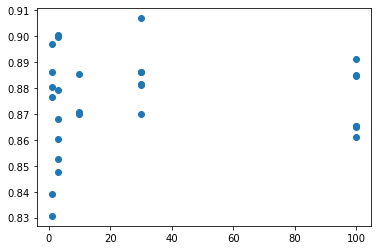

In [215]:
plot_against_score(grid_search.cv_results_,'param_clf__C' )

O C não foi testado independentemente de outras variaveis, no entanto valores menores parecem apresentar melhores resultados

###  TFIDF optimizado

Não é exatamente o mesmo que foi eleito pelo pipeline, mas este remove stop words e palavras redundantes porque ajuda a reduzir o ruido. Grava tambem o objeto num documento pickle

In [18]:
with open('tfidf_dump.p', 'wb') as f:
    tfidf = TfidfVectorizer(max_df=0.5 , min_df=4,ngram_range=(1, 2), norm='l2', token_pattern=r'\b\w{3,}\b'\
                            ,stop_words='english').fit(X)
    pickle.dump(tfidf, f)

In [19]:
len(tfidf.get_feature_names())

174366

In [20]:
vector = text2vector(X)
with open('vector_dump.p', 'wb') as f:
    pickle.dump(vector, f)
vector.shape

(40000, 174366)

## LogisticRegression booleana

In [22]:
x_train, x_test, y_train, y_test = train_test_split(vector, y_boolean, test_size=1/4)

dl = LogisticRegressionCV(max_iter = 1000, Cs=3, tol = 1e-3, cv=5,\
                          penalty='l2', solver='saga', n_jobs=-1).fit(x_train, y_train)
print(dl.score(x_train, y_train))
print(dl.score(x_test, y_test))

1.0
0.8968


## LogisticRegression multi-classe

In [23]:
x_train, x_test, y_train, y_test = train_test_split(vector, y, test_size=1/4)

dl = LogisticRegressionCV(max_iter = 1000, Cs=3, tol = 1e-3, cv=5, \
                          penalty='l2', solver='saga').fit(x_train, y_train)
print(dl.score(x_train, y_train))
print(dl.score(x_test, y_test))

0.7869666666666667
0.4336


O logistic regression é bastante bom com dados booleanos. Possivelmente poderia ser melhorado para dados multi classe se encontrassemos um TF-IDF adequado

## Linear SVC (booleana)

In [24]:
X1,X2,y1,y2=train_test_split(vector,y_boolean,test_size=1/4)

In [25]:
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    pipeline = Pipeline([
        ('svm' , LinearSVC(dual=True)) 
    ] , memory=tmpdir)
    
    grid_param = {
        'svm__C' : [0.1,1.0,5.0,10.0,100.0]
    }
    t0 =time.time()
    print('Started at'  , time.strftime("%H:%M:%S", time.localtime()))
    grid_search = GridSearchCV(pipeline, grid_param, n_jobs=-1, verbose=2).fit(X1,y1)
    print(f'Done at {time.strftime("%H:%M:%S", time.localtime())} took {str(time.time()-t0)} seconds')

Started at 04:36:54
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   59.7s finished


Done at 04:37:55 took 60.91223382949829 seconds


In [26]:
svm= grid_search.best_estimator_[0]
svm

LinearSVC()

In [27]:
ye=svm.predict(X2)

In [28]:
print('N erros(teste):',np.sum(y2!=ye))
print('Matriz confusao\n' , confusion_matrix(y2,ye), '\n')
print("Linear SVC Score train: ", svm.score(X1,y1))
print("Linear SVC Score test: ", svm.score(X2,y2))

N erros(teste): 1007
Matriz confusao
 [[4492  526]
 [ 481 4501]] 

Linear SVC Score train:  0.9992333333333333
Linear SVC Score test:  0.8993


In [29]:
with open('svc_bool_dump.p', 'wb') as f:
    pickle.dump(svm, f)

A maquina de suporte vetorial é bastante rápida a classificar os resultados, alem disso, apresentou os melhores resultados dentre todos os classificadores para classificacao binaria

# Linear SVC (multiclasse)

In [30]:
X1,X2,y1,y2=train_test_split(Normalizer().fit_transform(vector), y ,test_size=1/4)

In [31]:
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    pipeline = Pipeline([
        ('svm' , LinearSVC()) 
    ] , memory=tmpdir)
    
    grid_param = {
        'svm__dual' : [True, False],
        'svm__C' : [0.1,1.0,5.0,10.0,100.0]
    }
    t0 =time.time()
    print('Started at'  , time.strftime("%H:%M:%S", time.localtime()))
    grid_search = GridSearchCV(pipeline, grid_param, n_jobs=-1, verbose=2).fit(X1,y1)
    print(f'Done at {time.strftime("%H:%M:%S", time.localtime())} took {str(time.time()-t0)} seconds')

Started at 04:37:55
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 10.0min finished


Done at 04:48:04 took 608.1466355323792 seconds


In [32]:
svm= grid_search.best_estimator_[0]
svm

LinearSVC(C=0.1, dual=False)

In [33]:
ye=svm.predict(X2)

In [34]:
print('N erros(teste):',np.sum(y2!=ye))
conf_matrix = confusion_matrix(y2,ye)
print('Matriz confusao\n' , conf_matrix,  '\n')
print("Linear SVC Score train: ", svm.score(X1,y1))
print("Linear SVC Score test: ", svm.score(X2,y2))

N erros(teste): 5599
Matriz confusao
 [[1894   15   24   60   11   10    2  107]
 [ 681   24   54   98   11   15    1   79]
 [ 505   18   75  161   36   21    1  103]
 [ 380   13   70  308   76   42    7  158]
 [  85    1   26   78  201  192   21  330]
 [  75    3   11   43  131  192   32  622]
 [  47    2    5   22   48  104   26  675]
 [ 107    3    4   24   50   80   19 1681]] 

Linear SVC Score train:  0.7711
Linear SVC Score test:  0.4401


Os resultados de treino e teste são bastantes dispares. O classificador pode-se dizer que se encontra em sobre aprendizagem. Através de reducao do criterio de regularizacao poderiamos mitigar este problema, no entanto os resultados de teste seriam tambem piores.

# Ridge (boolean)

In [35]:
X1,X2,y1,y2=train_test_split(vector,y_boolean,test_size=1/5)

In [36]:
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    pipeline = Pipeline([
        ('ridge' , RidgeClassifier()) 
    ] , memory=tmpdir)
    
    grid_param = {
        'ridge__alpha' : [0.1,1.0,5.0,10.0,100.0],
        'ridge__normalize':[True, False]
    }
    t0 =time.time()
    print('Started at'  , time.strftime("%H:%M:%S", time.localtime()))
    grid_search = GridSearchCV(pipeline, grid_param, n_jobs=-1, verbose=2).fit(X1,y1)
    print(f'Done at {time.strftime("%H:%M:%S", time.localtime())} took {str(time.time()-t0)} seconds')

Started at 04:48:04
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.6s finished


Done at 04:48:22 took 18.380524396896362 seconds


In [37]:
ridge= grid_search.best_estimator_[0]
ridge

RidgeClassifier()

In [38]:
ye=ridge.predict(X2)

In [39]:
print('N erros(teste):',np.sum(y2!=ye))
print("Ridge Score train: ", ridge.score(X1,y1))
print("Ridge SVC Score test: ", ridge.score(X2,y2))

N erros(teste): 800
Ridge Score train:  0.99521875
Ridge SVC Score test:  0.9


# Ridge (multiclasse)

In [40]:
X1,X2,y1,y2=train_test_split(vector,y,test_size=1/5)

In [41]:
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    pipeline = Pipeline([
        ('ridge' , RidgeClassifier()) 
    ] , memory=tmpdir)
    
    grid_param = {
        'ridge__alpha' : [0.1,1.0,5.0,10.0,100.0],
    }
    t0 =time.time()
    print('Started at'  , time.strftime("%H:%M:%S", time.localtime()))
    grid_search = GridSearchCV(pipeline, grid_param, n_jobs=-1, verbose=2).fit(X1,y1)
    print(f'Done at {time.strftime("%H:%M:%S", time.localtime())} took {str(time.time()-t0)} seconds')

Started at 04:48:23
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   55.0s finished


Done at 04:49:22 took 59.286417722702026 seconds


In [42]:
ridge= grid_search.best_estimator_[0]
ridge

RidgeClassifier(alpha=5.0)

In [43]:
ye=ridge.predict(X2)

In [44]:
print('N erros(teste):',np.sum(y2!=ye))
print('Matriz confusao\n' , confusion_matrix(y2,ye), '\n')
print("Ridge Score train: ", ridge.score(X1,y1))
print("Ridge SVC Score test: ", ridge.score(X2,y2))

N erros(teste): 4546
Matriz confusao
 [[1486   21   38   54    4    2    0   77]
 [ 504   16   38   74   11    7    2   55]
 [ 400   13   64  133   19   25    5   98]
 [ 317   14   84  209   48   42    9  131]
 [  66    4   15   75  146  149   18  300]
 [  47    2    9   35  115  160   20  569]
 [  34    2    6   11   35   69   20  527]
 [  78    3    4    9   41   67   11 1353]] 

Ridge Score train:  0.7715
Ridge SVC Score test:  0.43175


In [45]:
with open('RidgeMultidump.p', 'wb') as f:
    pickle.dump(ridge, f)

### MultinomialNB ( ‘Naive Bayes' ) (Multiclasse)

In [66]:
X1,X2,y1,y2=train_test_split(vector,y,test_size=1/4)

In [83]:
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    pipeline = Pipeline([
        ('multinb' , MultinomialNB()) 
    ] , memory=tmpdir)
    
    grid_param = {
        'multinb__alpha' : [0.1, 1, 10]
    }
    t0 =time.time()
    print('Started at'  , time.strftime("%H:%M:%S", time.localtime()))
    grid_search = GridSearchCV(pipeline, grid_param, n_jobs=-1, verbose=2).fit(X1,y1)
    print(f'Done at {time.strftime("%H:%M:%S", time.localtime())} took {str(time.time()-t0)} seconds')

Started at 16:16:16
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.2s finished


Done at 16:16:18 took 1.6507184505462646 seconds


In [84]:
multinb= grid_search.best_estimator_[0]
multinb

MultinomialNB(alpha=0.1)

In [85]:
y2e = multinb.predict(X2)

In [86]:
print('N erros(teste):',np.sum(y2!=y2e))
print('Matriz confusao\n' , confusion_matrix(y2,ye), '\n')
print('Score ', multinb.score(X2, y2))

N erros(teste): 5843
Matriz confusao
 [[   0    0    0    0    0    0    0    0    0]
 [1009 1007    0    0    0    0    0    0    0]
 [ 473  481    0    0    0    0    0    0    0]
 [ 491  508    0    0    0    0    0    0    0]
 [ 529  562    0    0    0    0    0    0    0]
 [ 478  444    0    0    0    0    0    0    0]
 [ 553  609    0    0    0    0    0    0    0]
 [ 423  452    0    0    0    0    0    0    0]
 [ 960 1021    0    0    0    0    0    0    0]] 

Score  0.4157


### MultinomialNB ( ‘Naive Bayes' ) (Boolean)

In [71]:
X1,X2,y1,y2=train_test_split(vector,y_boolean,test_size=1/4)

In [72]:
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    pipeline = Pipeline([
        ('multinb' , MultinomialNB()) 
    ] , memory=tmpdir)
    
    grid_param = {
        'multinb__alpha' : [0.1, 1, 10]
    }
    t0 =time.time()
    print('Started at'  , time.strftime("%H:%M:%S", time.localtime()))
    grid_search = GridSearchCV(pipeline, grid_param, n_jobs=-1, verbose=2).fit(X1,y1)
    print(f'Done at {time.strftime("%H:%M:%S", time.localtime())} took {str(time.time()-t0)} seconds')

Started at 16:01:45
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.8s finished


Done at 16:01:46 took 1.3420095443725586 seconds


In [73]:
multinb= grid_search.best_estimator_[0]
multinb

MultinomialNB(alpha=1)

In [74]:
y2e = multinb.predict(X2)

In [75]:
print('N erros(teste):',np.sum(y2!=y2e))
print('Matriz confusao\n' , confusion_matrix(y2,ye), '\n')
print('Score ', multinb.score(X2, y2))

N erros(teste): 1190
Matriz confusao
 [[2482 2592]
 [2434 2492]] 

Score  0.881


### SGB (Multiclasse)

In [76]:
X1,X2,y1,y2=train_test_split(vector,y,test_size=1/4)

In [87]:
from sklearn.linear_model import SGDClassifier
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    pipeline = Pipeline([
        ('sgd' , SGDClassifier(early_stopping=True)) 
    ] , memory=tmpdir)
    
    grid_param = {
        'sgd__alpha' : [0.0001, 0.01 , 0.1, 1, 10]
    }
    t0 =time.time()
    print('Started at'  , time.strftime("%H:%M:%S", time.localtime()))
    grid_search = GridSearchCV(pipeline, grid_param, n_jobs=-1, verbose=2).fit(X1,y1)
    print(f'Done at {time.strftime("%H:%M:%S", time.localtime())} took {str(time.time()-t0)} seconds')

Started at 16:16:48
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   16.8s finished


Done at 16:17:06 took 18.59254217147827 seconds


In [88]:
SGB= grid_search.best_estimator_[0]
SGB

SGDClassifier(early_stopping=True)

In [89]:
y2e = SGB.predict(X2)
print('N erros(teste):',np.sum(y2!=y2e))
print('Matriz confusao\n' , confusion_matrix(y2,ye), '\n')
print('Score ', SGB.score(X2, y2))

N erros(teste): 5790
Matriz confusao
 [[   0    0    0    0    0    0    0    0    0]
 [1009 1007    0    0    0    0    0    0    0]
 [ 473  481    0    0    0    0    0    0    0]
 [ 491  508    0    0    0    0    0    0    0]
 [ 529  562    0    0    0    0    0    0    0]
 [ 478  444    0    0    0    0    0    0    0]
 [ 553  609    0    0    0    0    0    0    0]
 [ 423  452    0    0    0    0    0    0    0]
 [ 960 1021    0    0    0    0    0    0    0]] 

Score  0.421


O mesmo erro que ocorreu na classificacao de MultiNB ocorreu aqui. Acredito que é devido ao formato presente na matriz TF-IDF pois estes classificadores utilizam dados inteiros.  

## Decomposição em componentes principais

Temos 40000 documentos, com 170000 tokens, logo para reduzir a complixidade usamos LDA. A LDA remove os componentes com pouco relevo.

In [51]:
vector.shape

(40000, 174366)

In [52]:
pca = TruncatedSVD(n_components=100).fit(vector)

In [53]:
sum(pca.explained_variance_ratio_)

0.05306399911981366

In [54]:
with open('pca_dump.p' ,'wb') as f:
    pickle.dump(pca , f)

In [56]:
lista = [10,20,30,50,100,200,300,500,1000,1500]
variance_sum =[]
for n_comps in lista:
    pca = TruncatedSVD(n_components=n_comps, n_iter=2, ).fit(vector)
    variance_sum.append(pca.explained_variance_ratio_.sum())
    print(f'Num Componentes {n_comps : >5} ||  Variance { variance_sum[-1]: .10f}')

Num Componentes    10 ||  Variance  0.0099617900
Num Componentes    20 ||  Variance  0.0162114546
Num Componentes    30 ||  Variance  0.0216348239
Num Componentes    50 ||  Variance  0.0305994647
Num Componentes   100 ||  Variance  0.0489051279
Num Componentes   200 ||  Variance  0.0780041568
Num Componentes   300 ||  Variance  0.1019431901
Num Componentes   500 ||  Variance  0.1415056050
Num Componentes  1000 ||  Variance  0.2134037217
Num Componentes  1500 ||  Variance  0.2654003144


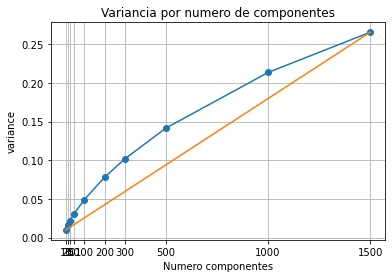

In [57]:
plt.plot(lista, variance_sum, marker='o')
plt.plot([lista[0], lista[-1]] , [variance_sum[0], variance_sum[-1]])

plt.xlabel('Numero componentes')
plt.xticks(lista)
plt.ylabel('variance')
plt.title('Variancia por numero de componentes')
plt.grid(True)

In [ ]:
with open('pca_dump.p' , 'rb') as f:
    global pca
    pca = pickle.load(f)

In [59]:
vec = pca.transform(vector)
vec.shape

(40000, 1500)

In [ ]:
dl = LogisticRegressionCV(Cs=3, max_iter=1000, multi_class='auto', n_jobs=-1, penalty='l2', solver='saga', 
                     tol=0.001).fit(vec, y_boolean)
print(dl.score(vec, y_boolean))
for target, score in dl.scores_.items():
    print(f'Class {target} \nScore {score}\n\n')

In [ ]:
dl = LogisticRegressionCV(Cs=3, max_iter=1000,  n_jobs=-1, penalty='l2', solver='saga', 
                     tol=0.001).fit(vec, y)
print(dl.score(vec, y))
for target, score in dl.scores_.items():
    print(f'Class {target} \nScores\n{score}\n\n')

# Clustering

Depois de termos os componentes principais podemos partir para o clustering

## Clustering, demora um bocado. Tipo 20 minutos para 100 componentes
Ajuda a calcular o numero de cluster otimo, entre 8 e max_k

In [170]:
min_k = len(np.unique(y))
max_k = 100
indx = np.linspace(min_k,max_k, num=20, dtype=np.uint8)
sse = []

for k in indx:
    kmeans = KMeans(n_clusters = k)

    sse.append(kmeans.fit(x_train).inertia_)
    print (str(k) + ": "+ str(silhouette_score(x_train, kmeans.labels_, metric='euclidean')))

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_sparse'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


8: 0.00033744958525772637


KeyboardInterrupt: 

In [ ]:
plt.plot(indx, sse, marker='o')
plt.plot([min_k, max_k] , [sse[0], sse[len(sse)-1]])


plt.xlabel('Clusters Centroides')
plt.xticks(indx)
plt.ylabel('SSE')
plt.title('SSE por número de clusters')
plt.grid(True)


In [ ]:
x1, y1 = min_k, sse[0]
x2, y2 = max_k, sse[len(sse)-1]

distances = []
for i in range(len(wcss)):
    x0 = indx[i]
    y0 = wcss[i]
    numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
    denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    distances.append(np.round(numerator/denominator , 6))

best_n = indx[distances.index(max(distances))]
print(best_n)

In [ ]:
with open('dump_cluster.p ', 'wb') as f:
    pickle.dump({
        'indx' : indx,
        'sse' : sse,
        'distances' : distances,
        'best_n' : best_n
    }, f)

In [ ]:
km = KMeans(n_clusters=best_n).fit(x_train)

In [ ]:
print("Top terms per cluster:")
original_space_centroids = pca.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = tfidf.get_feature_names()
for i in range(len(km.cluster_centers_)):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end=',')
    print()

# Bibliografia

### Geral
- Slides Professor

### Pré processamento do texto
- https://blog.ekbana.com/pre-processing-text-in-python-ad13ea544dae
- https://medium.com/@wenxuan0923/feature-extraction-from-text-using-countvectorizer-tfidfvectorizer-9f74f38f86cc

### Escolher o classificador
- https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

### Grid Search
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
- https://www.youtube.com/watch?v=Gol_qOgRqfA

### Pipeline
- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline

### Clustering
- https://medium.com/hanman/data-clustering-what-type-of-movies-are-in-the-imdb-top-250-7ef59372a93b
- https://jtemporal.com/kmeans-and-elbow-method/

### Naive Bayse
- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

### Decomposição PCA/LSA
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD
- https://www.datascienceassn.org/sites/default/files/users/user1/lsa_presentation_final.pdf
- https://towardsdatascience.com/latent-semantic-analysis-intuition-math-implementation-a194aff870f8